<a href="https://colab.research.google.com/github/SomTambe/omniglot-bcs/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/data_background.mat
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/splines.py

--2020-06-25 06:17:11--  https://github.com/SomTambe/omniglot-bcs/raw/master/data_background.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SomTambe/omniglot-bcs/master/data_background.mat [following]
--2020-06-25 06:17:12--  https://raw.githubusercontent.com/SomTambe/omniglot-bcs/master/data_background.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21514095 (21M) [application/octet-stream]
Saving to: ‘data_background.mat’

data_background.mat 100%[===================>]  20.52M  31.0MB/s    in 0.7s    

2020-06-25 06:17:15 (31.0 MB/s) - ‘data_background.mat’ saved [21514095/21514095]

--202

In [2]:
import splines
import torch
import glob
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
import scipy
!nvidia-smi

Thu Jun 25 06:17:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
back_dict=splines.mat_to_dict()

In [4]:
spline_prims=splines.spline_dict(back_dict)
images=splines.dict_images()

In [5]:
len(spline_prims) # Since languages are 30, should be equal to 30

30

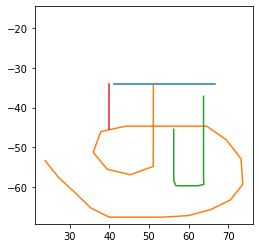

In [6]:
# Let us try to plot a character. Taking an example for a very weird character.
# I found one in the Grantha alphabet. Let us see how its 25-point spline representation looks.

splines.plot_char(spline_prims['Grantha'][1][3][0])
# Note that different colors denote different stokes.

In [7]:
np.ones((5,4))-99

array([[-98., -98., -98., -98.],
       [-98., -98., -98., -98.],
       [-98., -98., -98., -98.],
       [-98., -98., -98., -98.],
       [-98., -98., -98., -98.]])

<class 'numpy.float64'> 14.059844248375477


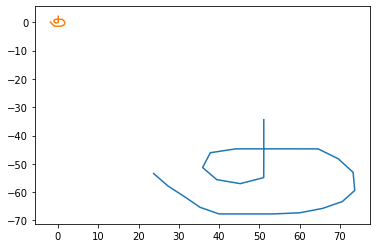

In [8]:
arr=spline_prims['Grantha'][1][3][0][1]
plt.plot(arr[:,0],arr[:,1])
mu_x=np.mean(arr[:,[0]])
mu_y=np.mean(arr[:,[1]])
std_x=np.std(arr[:,[0]])
std_y=np.std(arr[:,[1]])
print(type(std_x),std_x)
copy=np.concatenate((((arr[:,0]-mu_x)/std_x).reshape(25,1),((arr[:,1]-mu_y)/std_y).reshape(25,1)),axis=1)
# copy2=arr-np.array([mu_x,mu_y]) # same as copy, very interesting still don't understand why.
plt.plot(copy[:,0],copy[:,1])
plt.show()

In [9]:
# Our task now remains to train a variational autoencoder on a 2 - unit output for the above.

In [10]:
class encoder(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim=latent_dim
        self.encode=nn.Sequential(
            nn.Linear(50,1000),
            nn.ReLU(True),
            nn.Linear(1000,1000),
            nn.ReLU(True),
            nn.Linear(1000,2*self.latent_dim),
        )
        self.mu=nn.Linear(2*self.latent_dim,self.latent_dim)
        self.var=nn.Linear(2*self.latent_dim,self.latent_dim)
        
    def forward(self,x):
        x=self.encode(x)
        return [self.mu(x),self.var(x)]

In [11]:
class decoder(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim=latent_dim
        self.decode=nn.Sequential(
            nn.Linear(self.latent_dim,1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Linear(1000,50),
        )
        
    def forward(self,x):
        return self.decode(x)

In [12]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [13]:
# glob.glob('./**/*.png',recursive=True)
# Will store all filenames of background set images

In [14]:
count=0
for lang in spline_prims :
        # spline_prims[lang][char][inst][0][primitive]
        for i,char in enumerate(spline_prims[lang]) :
            # char = characters of lang
            for j,inst in enumerate(char) :
                # inst = character instance
                for k,primitive in enumerate(inst[0]):
                    count+=1
print('number of total strokes :',count)

number of total strokes : 48762


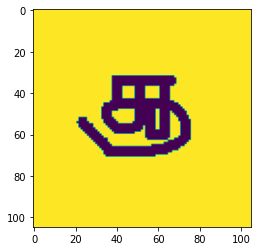

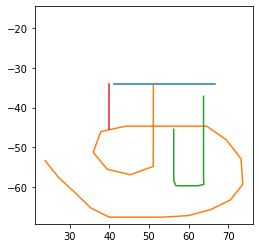

Success !


In [15]:
# images[lang][character][0]['image'][instance][0] -> (105,105) numpy ndarray
# Plotting the same characters, real image vs. the strokes.
img=images['Grantha'][1][0]['image'][3][0]
plt.imshow(img)
plt.show()
splines.plot_char(spline_prims['Grantha'][1][3][0])
print("Success !")

In [16]:
# Now we go on to build the custom dataset class for our data.
# Since our data is not in the form of a direct mapping, what 
# I could have done is that stacked all the data in the form of a matrix. But I wont 
# do that, instead I will use an iterable dataset which is supported by PyTorch dataloader.

In [17]:
from torch.utils.data import IterableDataset, DataLoader
class OmniglotData(IterableDataset):
    """
    Iterable dataset for the 25-spline to 2 vector encoding purpose.
    Expected form to pass data in form of "spline_prims[lang][char][inst][0][primitive]"
    Args:
        data (dict): Data in the same format as used everywhere in our application.
    """
    def __init__(self,data):
        self.data=data
    
    def normalize(self,arr):
        mu_x=np.mean(arr[:,[0]])
        mu_y=np.mean(arr[:,[1]])
        std_x=np.std(arr[:,[0]])
        std_y=np.std(arr[:,[1]])
        # return np.concatenate((((arr[:,0]-mu_x)/std_x).reshape(25,1),((arr[:,1]-mu_y)/std_y).reshape(25,1)),axis=1)
        return np.concatenate((((arr[:,0]-mu_x)).reshape(25,1),((arr[:,1]-mu_y)).reshape(25,1)),axis=1)
        
    def stream(self):
        # spline_prims[lang][char][inst][0][primitive]
        for lang in self.data:
            for char in self.data[lang]:
                for inst in char:
                    for prim in inst[0]:
                        # yield torch.tensor(prim.reshape(-1)).float()
                        yield torch.tensor(self.normalize(prim).reshape(-1)).float()
    
    def __iter__(self):
        # print(count)
        return self.stream()

In [18]:
def gen_latent(mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

def loss_function(*args):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        # kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

In [23]:
enc=encoder(latent_dim=3).to(device)
dec=decoder(latent_dim=3).to(device)

In [24]:
dataset=OmniglotData(spline_prims)
data_loader=DataLoader(dataset,batch_size=32,shuffle=False)

In [25]:
optimEnc=optim.Adam(enc.parameters(),lr=2e-4)
optimDec=optim.Adam(dec.parameters(),lr=2e-4)

In [26]:
# Yaay, everything is working ! Let us train the encoder now !
losses=[]
import time
num_epochs=150
for epoch in range(num_epochs):
    running_loss=.0
    running_reconst=.0
    running_kld=.0
    start=time.time()
    for i,data in enumerate(data_loader):
        # start=time.time()
        optimEnc.zero_grad(),optimDec.zero_grad()
        data=data.to(device)
        mu,var=enc(data)
        mid=gen_latent(mu,var)
        out=dec(mid)
        loss=loss_function(out,data,mu,var)
        real_loss,recons_loss,KLDL=loss['loss'],loss['Reconstruction_Loss'],loss['KLD']
        real_loss.backward()
        optimEnc.step()
        optimDec.step()
        # if (i+1)%print_intvl==0:
        #     print("[%d/%d] [%d] Loss: %.4f recons: %.4f KLD: %.4f Time elapsed: %.4f"%(epoch+1,num_epochs,i+1,real_loss.item(),recons_loss.item(),KLDL.item(),time.time()-start))
        running_loss+=real_loss.item()
        running_reconst+=recons_loss.item()
        running_kld+=KLDL.item()
    losses.append(running_loss)
    print("[%d/%d] [%d] Loss: %.4f recons: %.4f KLD: %.4f Time elapsed: %.4f"%(epoch+1,num_epochs,i+1,running_loss/32,running_reconst/32,running_kld/32,time.time()-start))
    # print("[%d/%d] Loss : %.4f Time elapsed : %.4f"%(epoch+1,num_epochs,running_loss,time.time()-start))

[1/150] [1524] Loss: 1702.1001 recons: 1352.2833 KLD: -349.8167 Time elapsed: 18.9411
[2/150] [1524] Loss: 1218.4120 recons: 917.3083 KLD: -301.1037 Time elapsed: 19.0824
[3/150] [1524] Loss: 1158.9781 recons: 868.9121 KLD: -290.0660 Time elapsed: 19.1211
[4/150] [1524] Loss: 1126.1241 recons: 837.9440 KLD: -288.1801 Time elapsed: 18.9819
[5/150] [1524] Loss: 1113.9883 recons: 828.1525 KLD: -285.8358 Time elapsed: 19.0215
[6/150] [1524] Loss: 1084.6511 recons: 799.1238 KLD: -285.5273 Time elapsed: 19.0534
[7/150] [1524] Loss: 1083.0367 recons: 798.0855 KLD: -284.9512 Time elapsed: 19.0731
[8/150] [1524] Loss: 1065.2865 recons: 778.9735 KLD: -286.3130 Time elapsed: 19.1074
[9/150] [1524] Loss: 1060.1013 recons: 773.7175 KLD: -286.3839 Time elapsed: 18.9618
[10/150] [1524] Loss: 1038.7314 recons: 752.9844 KLD: -285.7469 Time elapsed: 19.0330
[11/150] [1524] Loss: 1021.1012 recons: 734.3751 KLD: -286.7261 Time elapsed: 18.9555
[12/150] [1524] Loss: 1017.8883 recons: 731.4985 KLD: -286.389

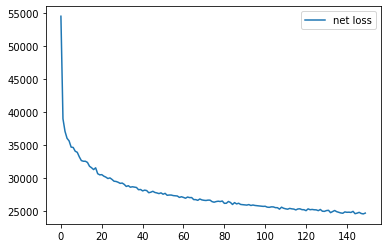

In [27]:
plt.plot(losses,label='net loss')
plt.legend()
plt.show()

In [28]:
from google.colab import files

torch.save(enc.state_dict(),'encoder_3_dim.pth')
torch.save(dec.state_dict(),'decoder_3_dim.pth')

In [30]:
# files.download('encoder_3_dim.pth')
files.download('decoder_3_dim.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !wget https://github.com/SomTambe/omniglot-bcs/raw/master/weights/decoder.pth
# !wget https://github.com/SomTambe/omniglot-bcs/raw/master/weights/encoder.pth

In [ ]:
enc.load_state_dict(torch.load('encoder.pth'))
dec.load_state_dict(torch.load('decoder.pth'))

In [ ]:
def eval_char(chr):
    """
    Function to show decoded character to see how the encoder has been trained.

    Args:
        chr (numpy array): Character to be evaluated.
    """
    # spline_prims['Grantha'][1][3][0]
    pred=[]
    enc.eval()
    dec.eval()
    for prim in chr :
        prim=normalize(prim)
        prim=torch.tensor(prim).to(device).reshape(-1).unsqueeze(0).float()
        mu,var=enc(prim)
        mid=gen_latent(mu,var)
        out=dec(mid).squeeze().reshape(25,2) # generated primitive
        pred.append(out.detach().cpu().numpy())

    return splines.plot_char(pred)
def normalize(arr):
        mu_x=np.mean(arr[:,[0]])
        mu_y=np.mean(arr[:,[1]])
        std_x=np.std(arr[:,[0]])
        std_y=np.std(arr[:,[1]])
        return np.concatenate((((arr[:,0]-mu_x)).reshape(25,1),((arr[:,1]-mu_y)).reshape(25,1)),axis=1)

In [ ]:
CHAR=spline_prims['Sanskrit'][1][3][0]
print("Decoded")
eval_char(CHAR)
print("original")
splines.plot_char(CHAR)

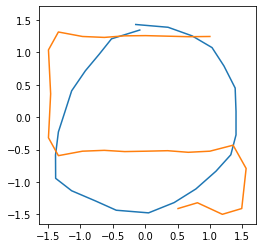

In [ ]:
# Comment out the .reshape(-1) part in the dataset class to test out this portion.
# Randomly plotting strokes to see whether they are different.
samp=[]
for c,dat in enumerate(data_loader):
    samp.append(dat)
    if c>0 :
        break
for _,c in enumerate(samp):
    # print(c.squeeze().detach().cpu().numpy().shape)
    plt.plot(c.squeeze().detach().cpu().numpy()[:,0],c.squeeze().detach().cpu().numpy()[:,1],'')
plt.axis('square')
plt.show()
# Just to make sure there is no problem with loading spline data